In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

In [2]:
# plotting style (optional!)
import matplotlib as mpl
from matplotlib import rc
mpl.style.use('classic')
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mlmodern}'

mpl.rc('xtick', labelsize=27) 
mpl.rc('ytick', labelsize=27)
mpl.rc('xtick', labelsize=27) 
mpl.rc('ytick', labelsize=27)

mpl.rcParams['xtick.major.size'] = 10.0
mpl.rcParams['xtick.major.width'] = 1.75
mpl.rcParams['ytick.major.size'] = 10.0
mpl.rcParams['ytick.major.width'] = 1.75

mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams['patch.linewidth'] = 2.0
mpl.rcParams['xtick.major.pad'] = 10.0
mpl.rcParams['ytick.major.pad'] = 10.0

mpl.rcParams['xtick.top'] = False
mpl.rcParams['ytick.right'] = False

mpl.rcParams['xtick.minor.size'] = 5.0
mpl.rcParams['xtick.minor.width'] = 1.75
mpl.rcParams['ytick.minor.size'] = 5.0
mpl.rcParams['ytick.minor.width'] = 1.75

mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.top'] = True

import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

# Figure 2: mass-magnitude relation

In [3]:
# load data from Pecaut & Mamajek (2013) table
data = np.genfromtxt('data/PecautMamajek2013_June2025.txt', dtype='str')
MGs, masses = pd.to_numeric(data[:,13], errors='coerce'), pd.to_numeric(data[:,30], errors='coerce')
mask = ((np.isnan(MGs) | np.isnan(masses)) | (((masses < 0.1) | (masses > 2.00)))) # masks for mass limits
MGs, masses = MGs[np.invert(mask)], masses[np.invert(mask)] # apply masks

In [4]:
# fourth-degree polynomial fit
poly_coeffs = np.polyfit(np.log10(masses), MGs, deg=4)
poly_coeffs

array([ 16.91206805,  24.95258266,   4.0433877 , -13.63108438,
         4.77092427])

In [5]:
# L_G ~ M_star^4 fit
intercept_L4 = np.mean(MGs + 10.0*np.log10(masses))
intercept_L4

4.908701384755666

In [6]:
# calculate grid for plot
x_grid_masses = np.linspace(0.1, 2.0, 10_000)
pred_MG_grid = np.polyval(poly_coeffs, np.log10(x_grid_masses))
simple_MG_grid = -2.5*4.0*np.log10(x_grid_masses) + intercept_L4

In [7]:
# calculate derivatives
x_grid_bins = 0.5*(x_grid_masses[1:] + x_grid_masses[:-1])
pred_dMG_dM_grid = np.diff(pred_MG_grid)/np.diff(x_grid_masses)
simple_dMG_dM_grid = np.diff(simple_MG_grid)/np.diff(x_grid_masses)

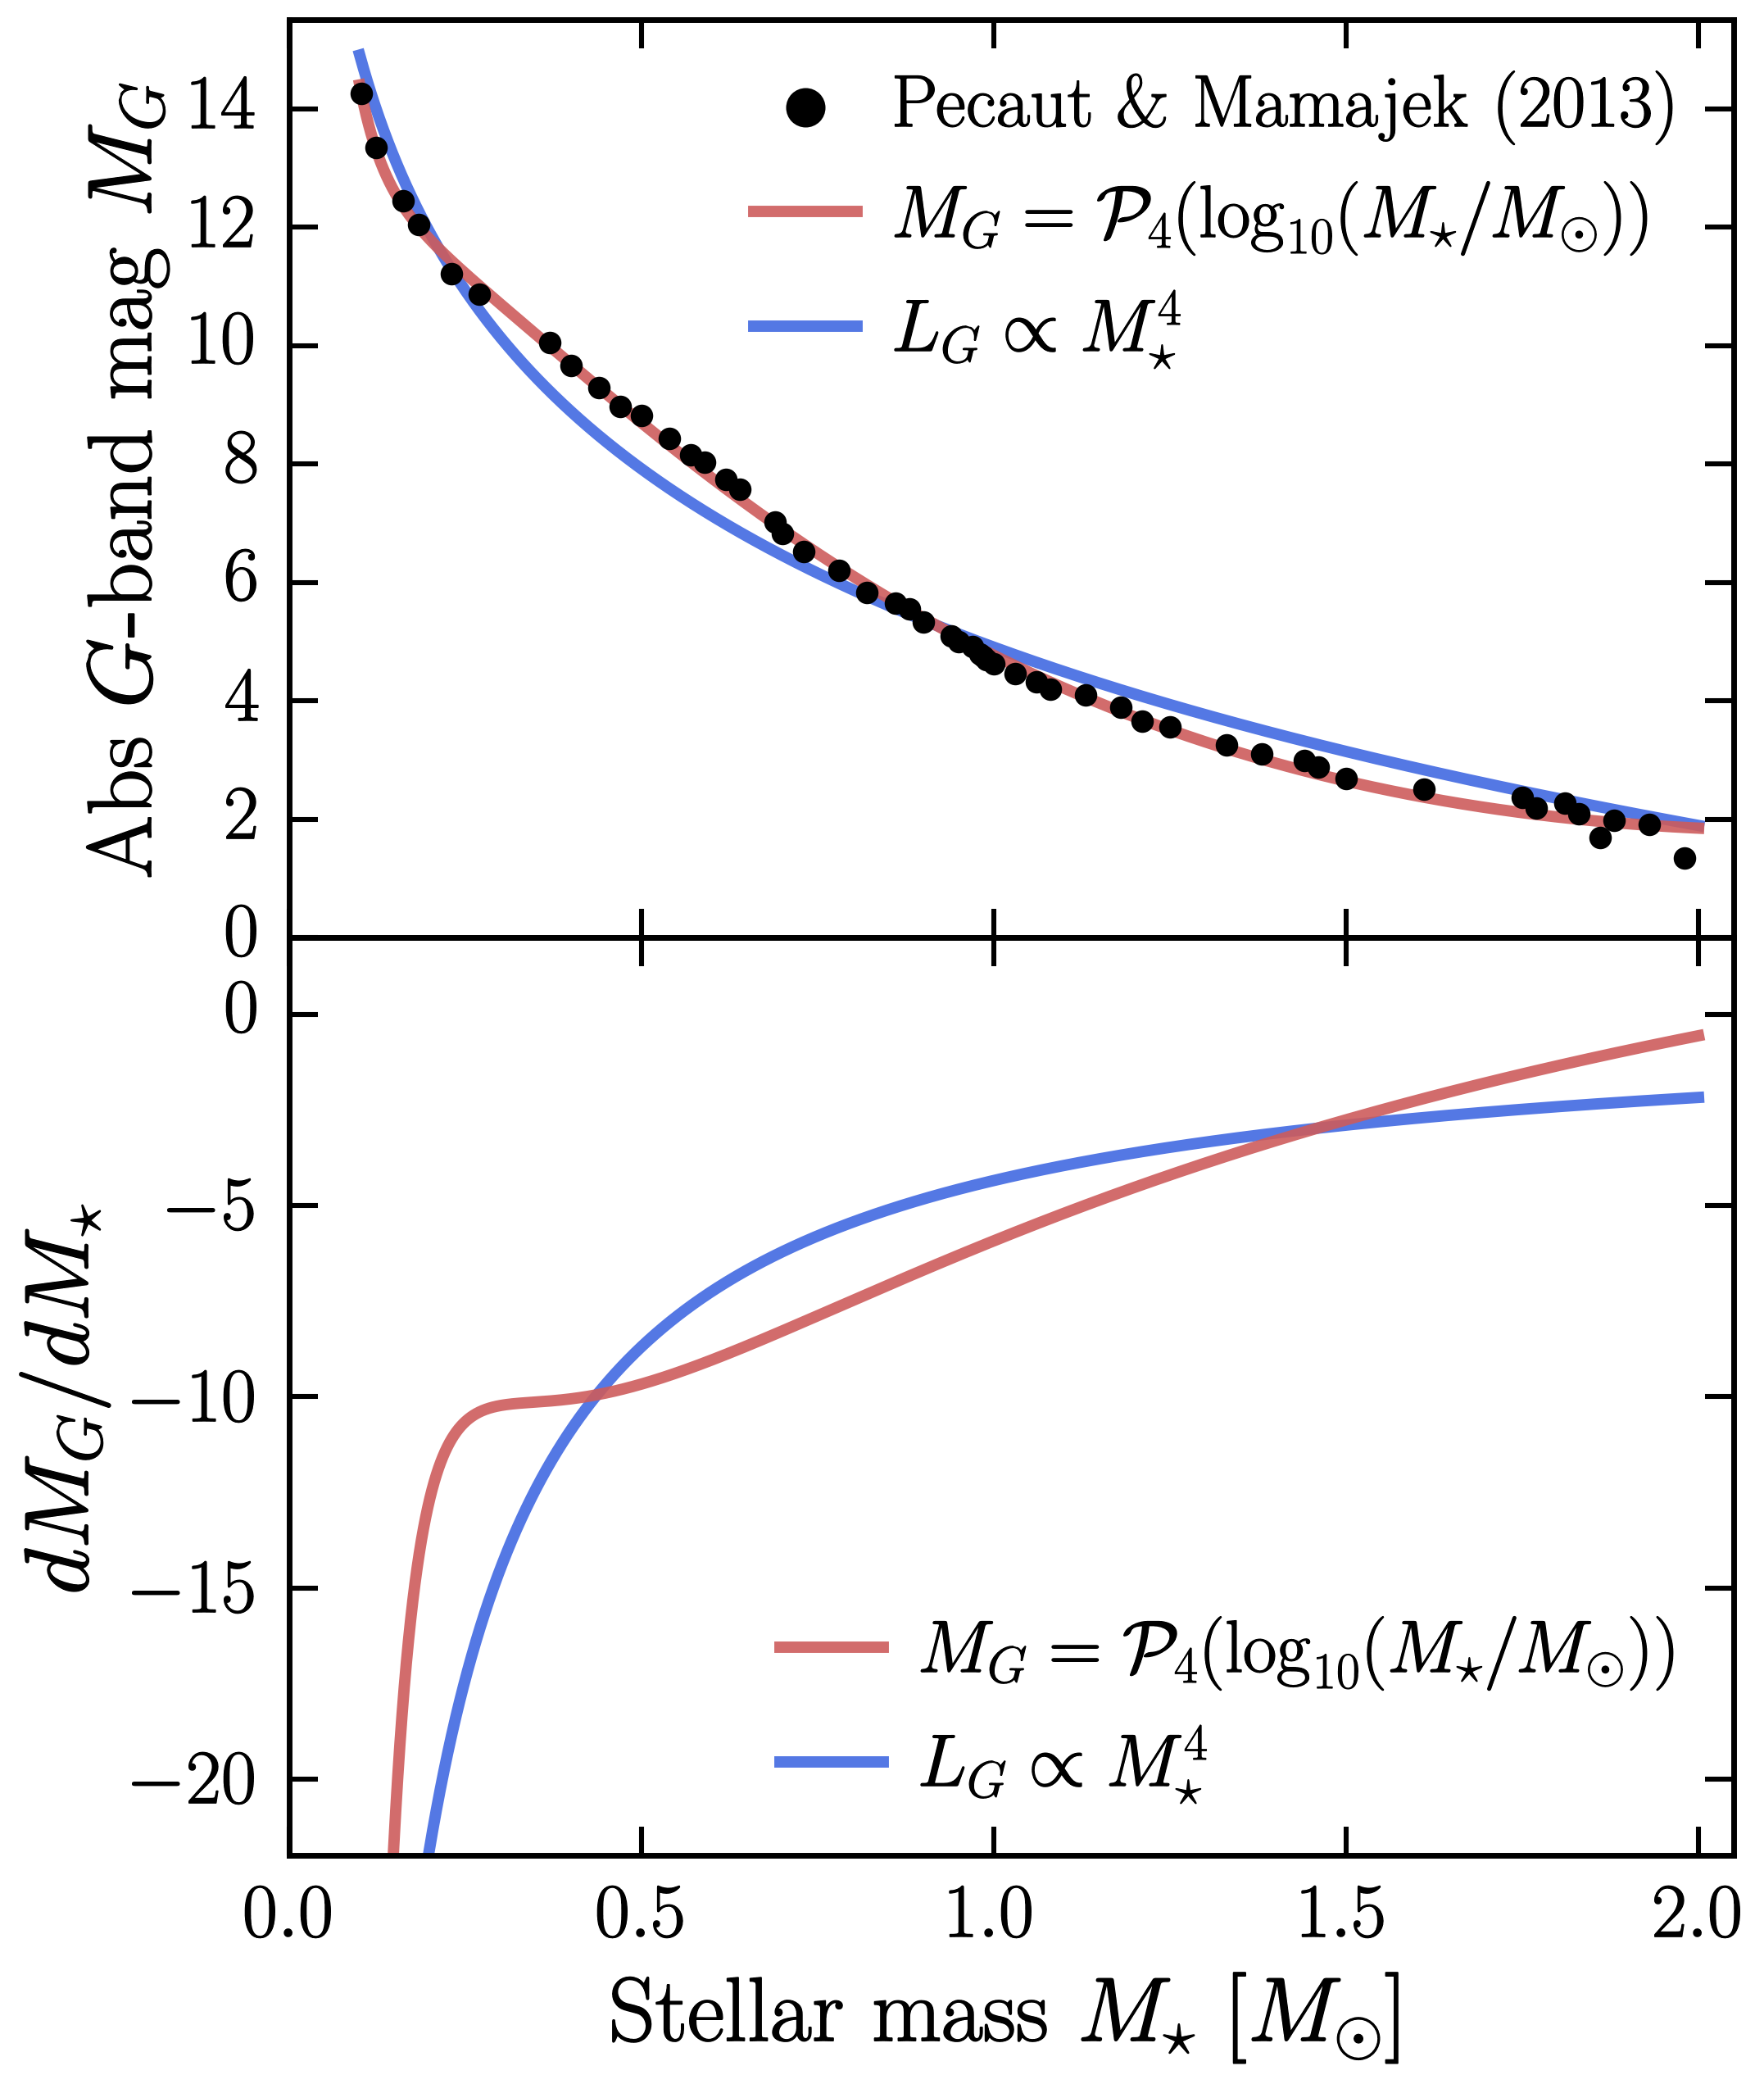

In [8]:
# make plot
fig, ax = plt.subplots(2, 1, figsize=(13*0.7,16*0.7), dpi=250, sharex=True, facecolor='white')
ax[0].scatter(masses, MGs, c='k', s=35, label=r'$\mathrm{Pecaut~\&~Mamajek~(2013)}$', zorder=10)
ax[0].plot(x_grid_masses, pred_MG_grid, c='indianred', lw=4, zorder=-1, alpha=0.9, label=r'$M_G = \mathcal{P}_4 (\log_{10}(M_\star / M_\odot))$')
ax[0].plot(x_grid_masses, simple_MG_grid, c='royalblue', lw=4, zorder=-2, alpha=0.9, label=r'$L_G \propto M_\star^4$')
ax[0].set_ylabel(r'$\mathrm{Abs}~G$-$\mathrm{band~mag}~M_G$', fontsize=32, labelpad=7)
ax[0].legend(scatterpoints=1, markerscale=2, handletextpad=0.2, borderaxespad=0.3, frameon=False, fontsize=26)
ax[0].set_xlim([0.0, 2.05])
ax[0].set_ylim([0.0, 15.5])

ax[1].plot(x_grid_bins, pred_dMG_dM_grid, c='indianred', lw=4, zorder=-1, alpha=0.9, label=r'$M_G = \mathcal{P}_4 (\log_{10}(M_\star / M_\odot))$')
ax[1].plot(x_grid_bins, simple_dMG_dM_grid, c='royalblue', lw=4, zorder=-2, alpha=0.9, label=r'$L_G \propto M_\star^4$')
ax[1].set_ylabel(r'$d M_G / d M_\star$', fontsize=32, labelpad=7)
ax[1].set_ylim([-22, 2.0])
ax[1].legend(loc='lower right', scatterpoints=1, handletextpad=0.2, borderaxespad=0.3, frameon=False, fontsize=26)

plt.subplots_adjust(hspace=0.0) 
ax[1].set_xlabel(r'$\mathrm{Stellar~mass}~M_\star~[M_\odot]$', fontsize=32, labelpad=7)
plt.show()

# Figure 3: volumetric mass function

In [9]:
# load data tabulated from Fig. 16 of Gaia Collaboration et al. (2021)
data = np.genfromtxt('Data/Gaia_VLF_tabulated.csv', delimiter=', ')
Gaia_MGs, Gaia_VLFs = data[:,0], data[:,1]

In [10]:
# determine limits
np.polyval(poly_coeffs, np.log10(np.array([0.1, 2.0])))

array([14.40488174,  1.85352861])

In [11]:
# cubic spline fit to VLF
mass_mask = (1.8535286 < Gaia_MGs) & (Gaia_MGs < 14.40488174)
Gaia_MGs, Gaia_VLFs = Gaia_MGs[mass_mask], Gaia_VLFs[mass_mask] # 0.1 < M_star < 2.0
VLF_cubic_spline = CubicSpline(Gaia_MGs, Gaia_VLFs) # fit spline

# grid for plot
x_grid_MGs = np.linspace(1.8535286, 14.40488174, 10_000)
pred_VLF_grid = VLF_cubic_spline(x_grid_MGs)

In [12]:
# convert stellar mass grid to absolute mags
x_grid_masses = np.linspace(0.1, 2.0, 10_000)
poly_coeffs = np.array([16.91206805,  24.95258266,   4.0433877 , -13.63108438,
                        4.77092427])
pred_MG_grid = np.polyval(poly_coeffs, np.log10(x_grid_masses))
simple_MG_grid = -2.5*4*np.log10(x_grid_masses) + 4.90870138

# convert absolute mags to VLF
VLF_preds = VLF_cubic_spline(pred_MG_grid)
VLF_preds_simple = VLF_cubic_spline(pred_MG_grid)

# convert from VLF to VMF using d MG / dM
x_grid_bins = 0.5*(x_grid_masses[1:] + x_grid_masses[:-1])
VLF_preds_bins = 0.5*(VLF_preds[1:] + VLF_preds[:-1])
pred_dMG_dM_grid = np.diff(pred_MG_grid)/np.diff(x_grid_masses)
VMF_preds = VLF_preds_bins*np.abs(pred_dMG_dM_grid)

# also compute VMF using L_G ~ M_star^4 relation
VLF_preds_bins_simple = 0.5*(VLF_preds_simple[1:] + VLF_preds_simple[:-1])
pred_dMG_dM_grid_simple = np.diff(simple_MG_grid)/np.diff(x_grid_masses)
VMF_preds_simple = VLF_preds_bins_simple*np.abs(pred_dMG_dM_grid_simple)

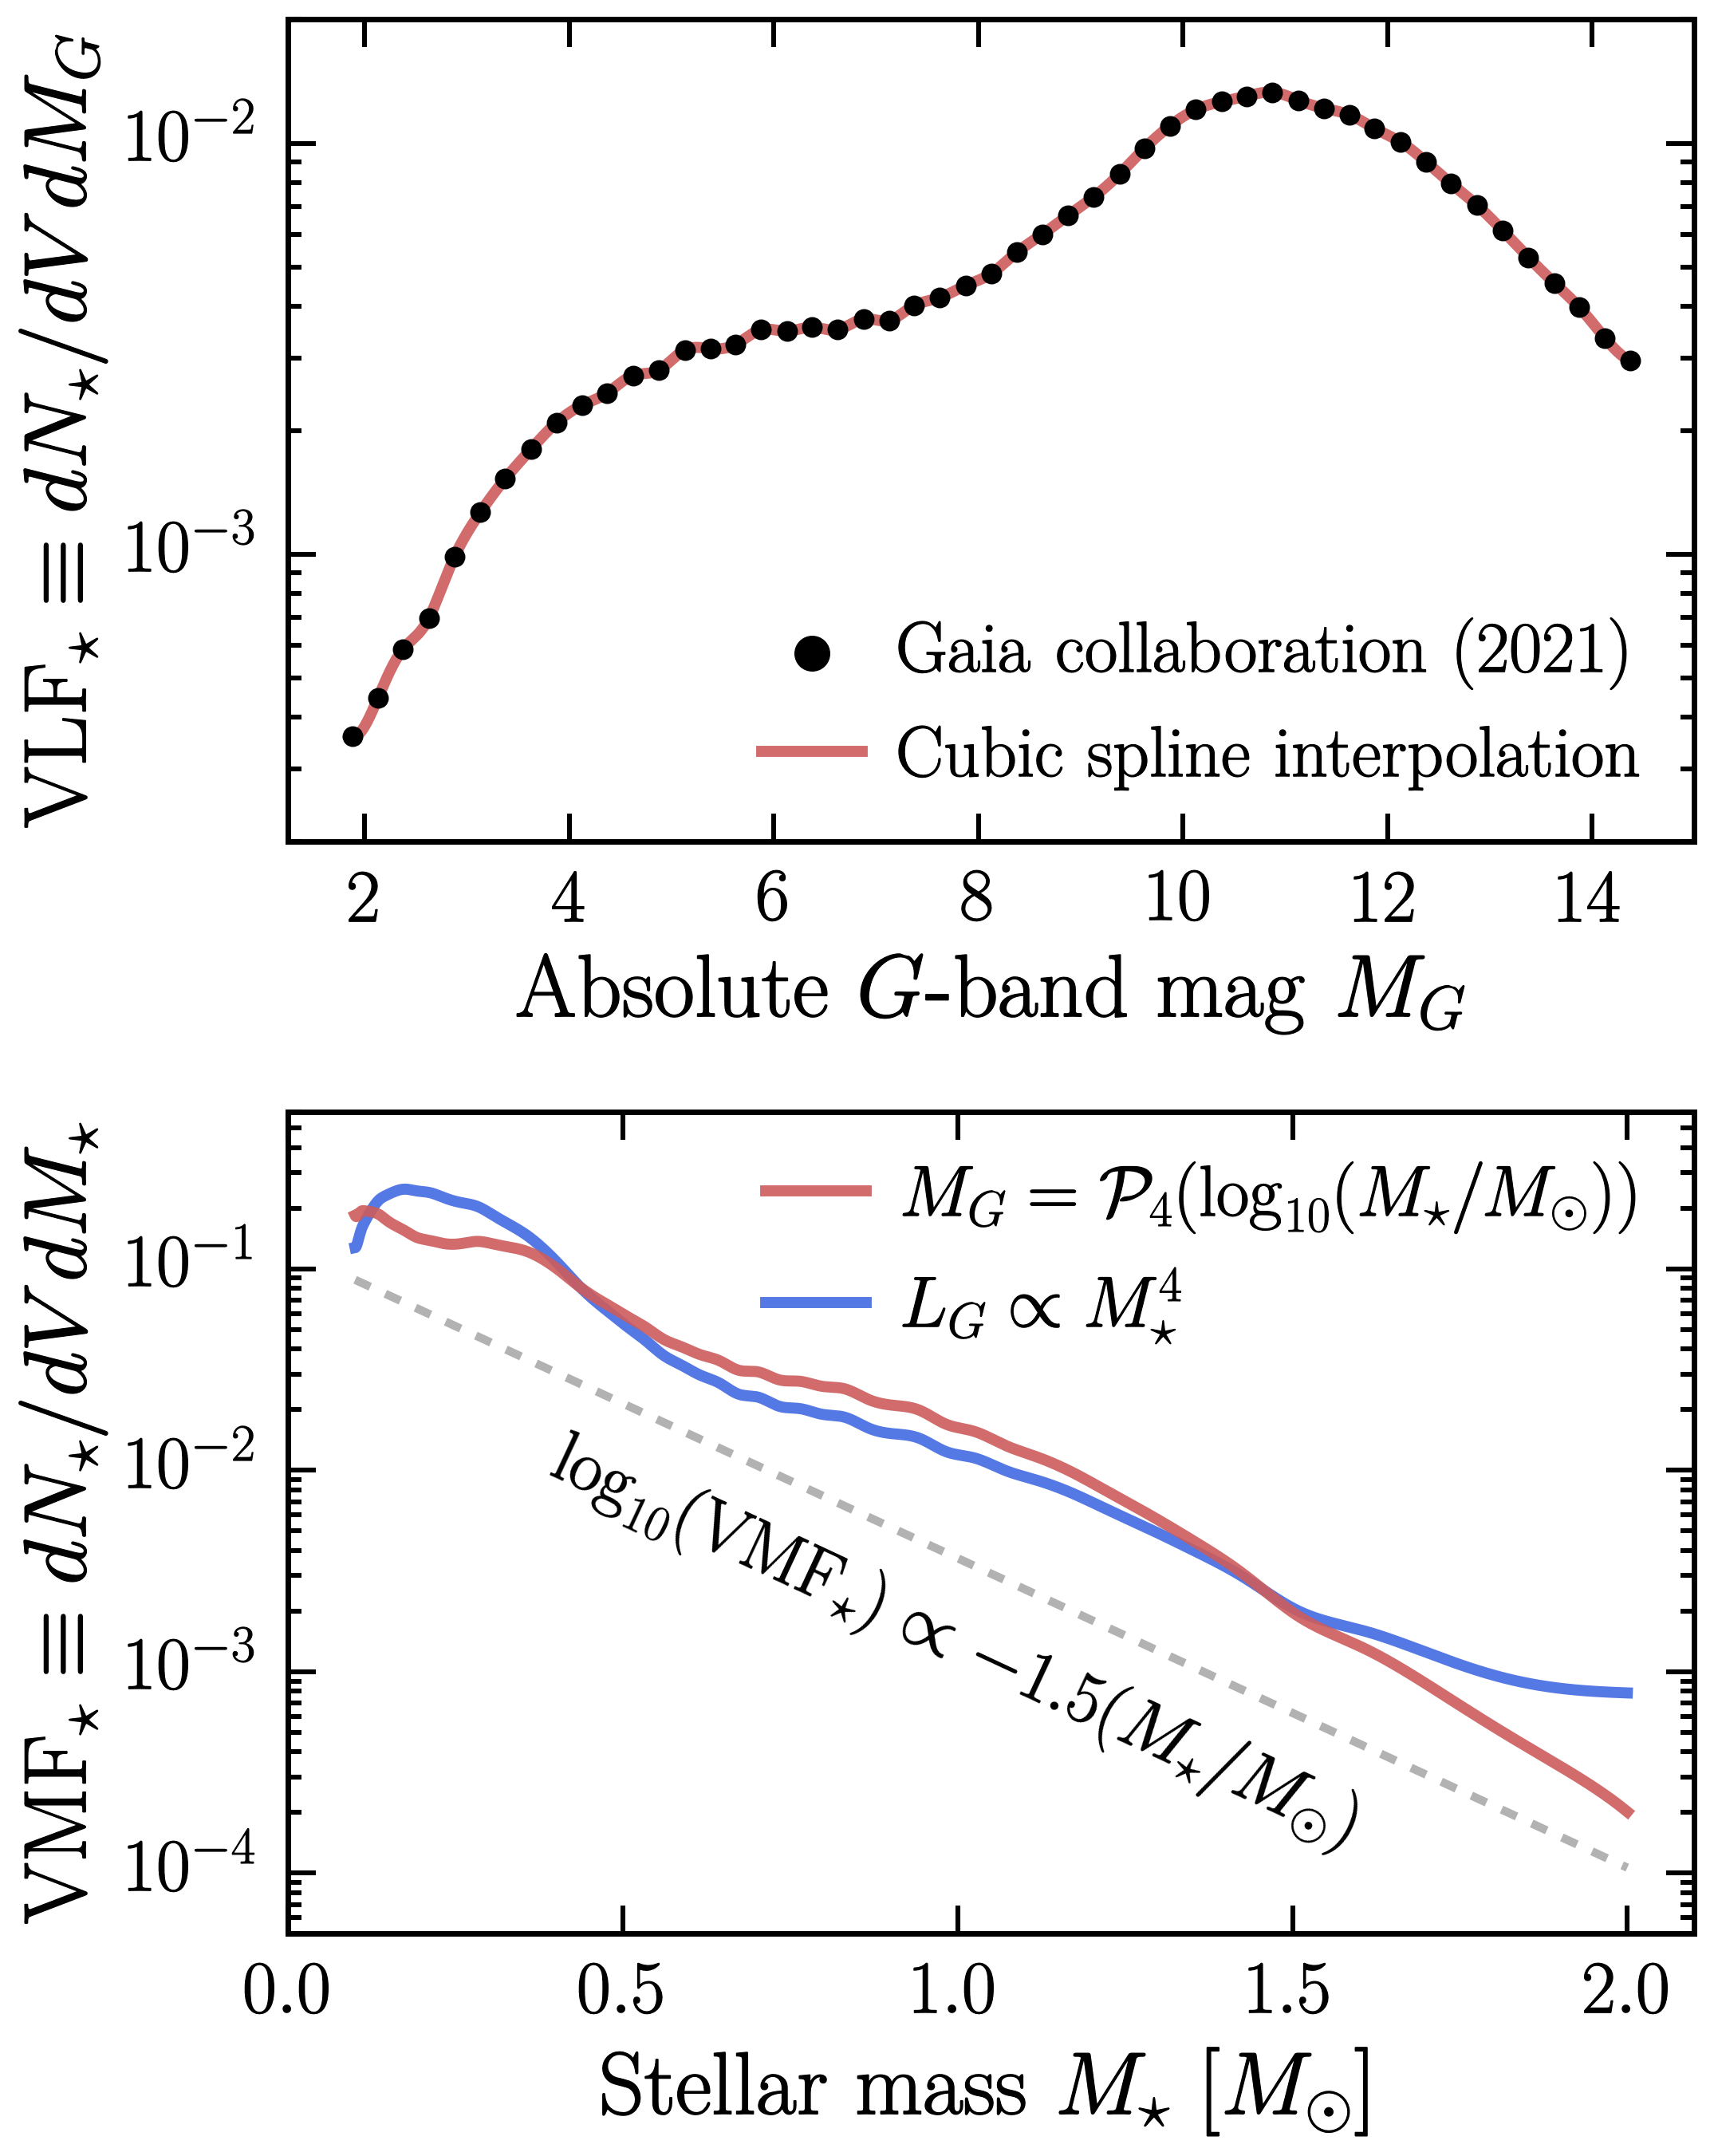

In [13]:
# make plot
fig, ax = plt.subplots(2, 1, figsize=(9.1,12.0), dpi=250, facecolor='white')
ax[0].scatter(Gaia_MGs, Gaia_VLFs, s=30, c='k', label=r'$\mathrm{Gaia~collaboration~(2021)}$')
ax[0].plot(x_grid_MGs, pred_VLF_grid, c='indianred', lw=4, zorder=-1, alpha=0.9, label=r'$\mathrm{Cubic~spline~interpolation}$')
ax[0].set_xlabel(r'$\mathrm{Absolute}~G$-$\mathrm{band~mag}~M_G$', labelpad=7, fontsize=32)
ax[0].set_ylabel(r'$\mathrm{VLF}_\star \equiv d N_\star/dV dM_G$', fontsize=32, labelpad=7)
ax[0].set_yscale('log')
ax[0].legend(loc='lower right', markerscale=2, scatterpoints=1, handletextpad=0.2, borderaxespad=0.3, frameon=False, fontsize=26)
ax[0].set_xlim([1.25, 15.0])
ax[0].set_ylim([2e-4, 2e-2])

ax[1].plot(x_grid_bins, VMF_preds, c='indianred', lw=4, zorder=-1, alpha=0.9, label=r'$M_G = \mathcal{P}_4 (\log_{10}(M_\star / M_\odot))$')
ax[1].plot(x_grid_bins, VMF_preds_simple, c='royalblue', lw=4, zorder=-2, alpha=0.9, label=r'$L_G \propto M_\star^4$')
ax[1].plot(x_grid_bins, 10**(-0.9 - 1.53625598*x_grid_bins), c='k', ls='--', lw=3, alpha=0.3, zorder=-1)
ax[1].set_xlabel(r'$\mathrm{Stellar~mass}~M_\star~[M_\odot]$', labelpad=7, fontsize=32)
ax[1].set_ylabel(r'$\mathrm{VMF}_\star \equiv d N_\star/dV dM_\star$', labelpad=7, fontsize=32)
ax[1].set_yscale('log')
ax[1].set_xlim([0.0, 2.1])
ax[1].set_ylim([5e-5, 0.6])
ax[1].text(1.0, 1.35e-3, r'$\log_{10}(\mathrm{VMF}_\star) \propto -1.5 (M_\star/M_\odot)$', rotation=-25, horizontalalignment='center', verticalalignment='center', fontsize=26)
ax[1].legend(loc='upper right', scatterpoints=1, handletextpad=0.2, borderaxespad=0.3, frameon=False, fontsize=26)

plt.subplots_adjust(hspace=0.33) 
plt.show()

# Figure 4: Gaia's astrometric precision

In [14]:
# Gaiamock's astrometric precision function
def al_uncertainty_per_ccd_interp(G):
    '''
    This gives the uncertainty *per CCD* (not per FOV transit), taken from Fig 3 of https://arxiv.org/abs/2206.05439
    This is the "EDR3 adjusted" line from that Figure, which is already inflated compared to the formal uncertainties.
    '''
    G_vals =    [ 4,    5,   6,     7,   8.2,  8.4, 10,    11,    12,  13,    14,   15,   16,   17,   18,   19,  20]
    sigma_eta = [0.4, 0.35, 0.15, 0.17, 0.23, 0.13,0.13, 0.135, 0.125, 0.13, 0.15, 0.23, 0.36, 0.63, 1.05, 2.05, 4.1]
    return np.interp(G, G_vals, sigma_eta)

In [15]:
# simple model for Gaia's astrometric uncertainty
def piecewise(x, a):
    return a*np.max([1.0*np.ones(len(x)), 10**(0.2*(x - 14.0))], axis=0)

# convenience function for fitting
def log_piecewise(x, a):
    return np.log10(a*np.max([1.0*np.ones(len(x)), 10**(0.2*(x - 14.0))], axis=0))

In [16]:
# data from Fig 3 of Holl et al. 2022 (between G = 6 - 19)
H23_fig3_xs = np.array([ 6,     7,   8.2,  8.4, 10,    11,    12,  13,    14,   15,   16,   17,   18,   19])
H23_fig3_ys = np.array([0.15, 0.17, 0.23, 0.13,0.13, 0.135, 0.125, 0.13, 0.15, 0.23, 0.36, 0.63, 1.05, 2.05])
H23_noise_levels = 1e3*H23_fig3_ys/np.sqrt(8)

In [17]:
# fit with log-piecewise function
popt, _ = curve_fit(log_piecewise, H23_fig3_xs, np.log10(H23_noise_levels), p0=(50.0))
print(popt) # if you make the break free, the best-fit function has a break at G ~ 14

[53.89888778]


In [18]:
# get grids for plot
G_grid = np.linspace(6.0, 19.0, 1000)
piecewise_sigma_fovs = piecewise(G_grid, 53.89888779)
Gaiamock_sigma_fovs = 1e3*al_uncertainty_per_ccd_interp(G_grid)/np.sqrt(8)

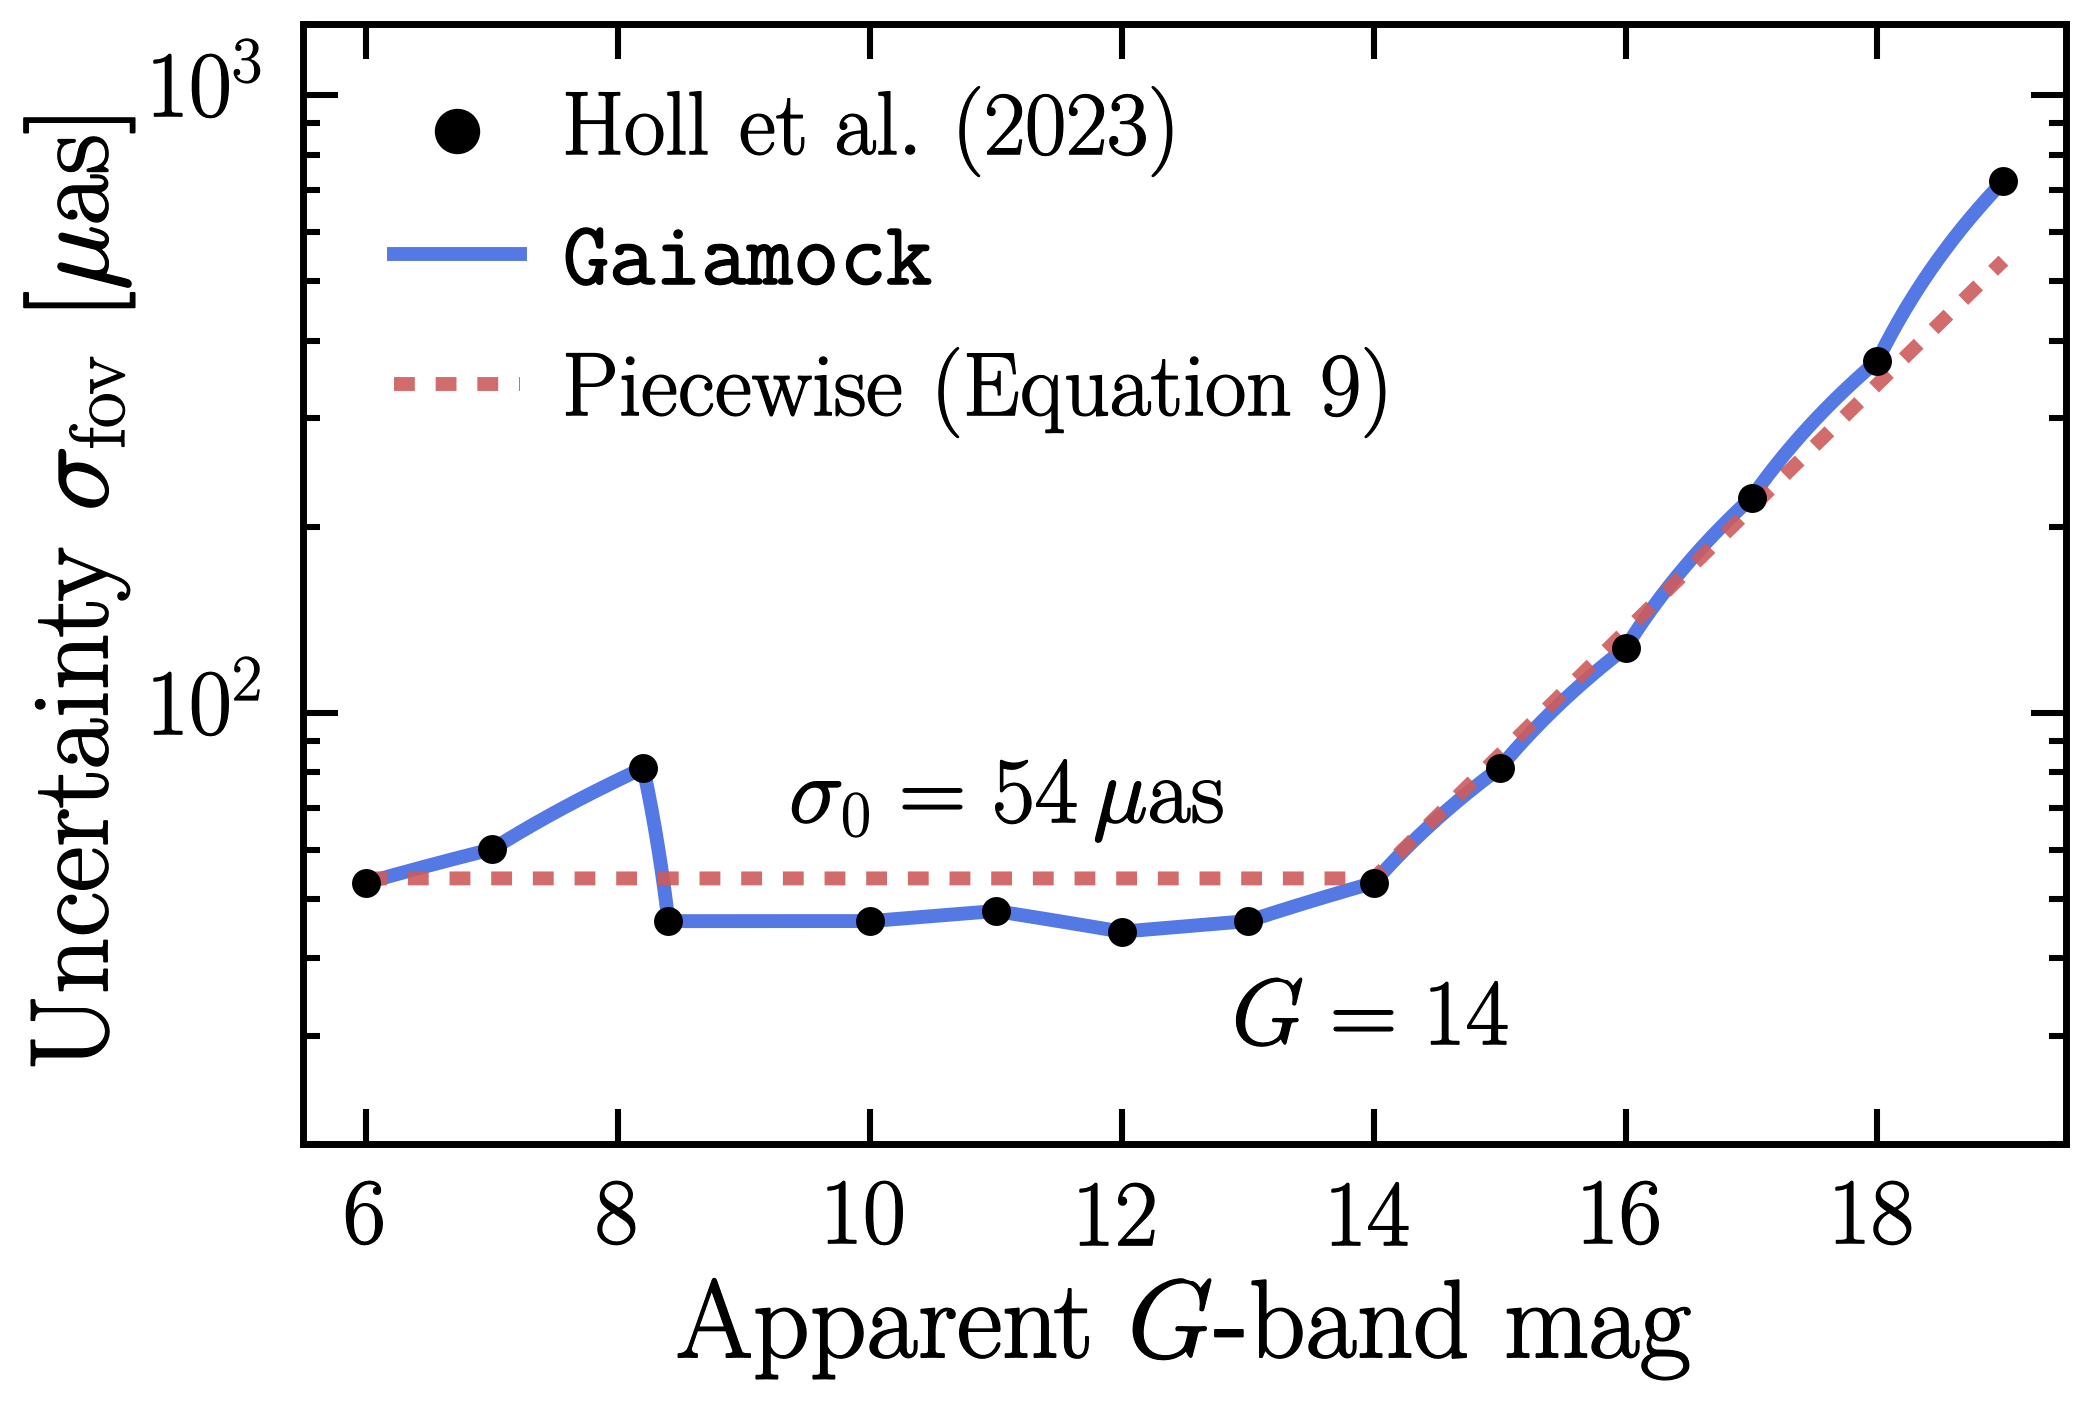

In [19]:
# make plot
plt.figure(dpi=250, figsize=(9.1, 5.6), facecolor='white')
plt.scatter(H23_fig3_xs, H23_noise_levels , c='k', s=40, zorder=10, label=r'$\mathrm{Holl~et~al.~(2023)}$')
plt.plot(G_grid, Gaiamock_sigma_fovs, c='royalblue', lw=4, alpha=0.9, label=r'$\mathrm{\texttt{Gaiamock}}$')
plt.plot(G_grid, piecewise_sigma_fovs, c='indianred', alpha=0.9, lw=4, ls='--', label=r'$\mathrm{Piecewise~(Equation~9)}$')
plt.yscale('log')
plt.xlim([5.5, 19.5])
plt.ylim([20, 1.3e3])
plt.xlabel(r'$\mathrm{Apparent}~G$-$\mathrm{band~mag}$', fontsize=32)
plt.ylabel(r'$\mathrm{Uncertainty}~\sigma_\mathrm{fov}~[\mu\mathrm{as}]$', fontsize=32)
plt.legend(loc='upper left', markerscale=1.75, scatterpoints=1, handletextpad=0.2, borderaxespad=0.3, frameon=False, fontsize=26)
plt.text(11.1, 72.0, r'$\sigma_0 = 54\, \mu \mathrm{as}$', horizontalalignment='center', verticalalignment='center', fontsize=27)
plt.text(14.0, 31.5, r'$G = 14$', horizontalalignment='center', verticalalignment='center', fontsize=27)
plt.show()